In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tacoma as tc
from tacoma.analysis import plot_contact_durations
from tacoma.analysis import plot_degree_distribution

# Load empirical networks

In [2]:
def normalized_nodes_time(df, tscale=20):
    nodes = np.union1d(df.i.unique(), df.j.unique())
    nodes_map = dict(zip(nodes, np.arange(len(nodes))))
    df.i = df.i.map(nodes_map)
    df.j = df.j.map(nodes_map)
    df.t = ((df.t - df.t.min())/20).astype('int')
    
    return df


def collect_SFHH():
    path = './data_eval/SFHH-conf-sensor.edges'
    df = pd.read_csv(path, names=['i', 'j', 't'])
    df['date'] = pd.to_datetime(df.t, unit='s')
    df['day'] = df.date.dt.date
    df = normalized_nodes_time(df)


    for grp, x in df.groupby('day'):
        x.to_parquet(f'./data_eval_split/SFHH/{grp}.parquet')


def collect_InVS():
    files = ['tij_InVS.dat', 'tij_InVS15.dat']
    path = './data_eval/'

    for i, file in enumerate(files):
        df = pd.read_csv(path + file, sep=' ', names=['t', 'i', 'j', 'Ci', 'Cj'])
        df['date'] = pd.to_datetime(df.t, unit='s')
        df['day'] = df.date.dt.date
        df = normalized_nodes_time(df)
        
        for grp, x in df.groupby('day'):
            x.to_parquet(f'./data_eval_split/InVS/f{i}_{grp}.parquet')


def collect_primaryschool():
    path = './data_eval/primaryschool.csv'
    df = pd.read_csv(path, sep='\t', names=['t', 'i', 'j', 'Ci', 'Cj'])
    df['date'] = pd.to_datetime(df.t, unit='s')
    df['day'] = df.date.dt.date
    df = normalized_nodes_time(df)

    for grp, x in df.groupby('day'):
            x.to_parquet(f'./data_eval_split/primaryschool/{grp}.parquet')


def collect_supermarket():
    files = ['wed17_1516.csv', 'thu25_1516.csv', 'thu25_1617.csv', 'fri19_1516.csv', 'fri26_1516.csv']
    path = './data_eval/'

    return [pd.read_csv(path + file) for file in files]


def collect_gallery():
    path = './data_eval/infectious/'

    for i, file in enumerate(os.listdir(path)):
        df = pd.read_csv(path + file, sep='\t', names=['t', 'i', 'j'])
        df['date'] = pd.to_datetime(df.t, unit='s')
        df['day'] = df.date.dt.date 
        df = normalized_nodes_time(df)   

        df.to_parquet(f'./data_eval_split/gallery/f{i}_{df.loc[0].day}.parquet')   


def collect_highschool():
    files = ['High-School_data_2013.csv', 'thiers_2012.csv', 'thiers_2011.csv']
    path = './data_eval/'

    for i, file in enumerate(files):
        if i == 0:
            sep = ' '
        else:
            sep = '\t'

        df = pd.read_csv(path + file, sep=sep, names=['t', 'i', 'j', 'Ci', 'Cj'])
        df['date'] = pd.to_datetime(df.t, unit='s')
        df['day'] = df.date.dt.date
        df = normalized_nodes_time(df)

        for grp, x in df.groupby('day'):
            x.to_parquet(f'./data_eval_split/highschool/f{i}_{grp}.parquet')

# Convert to tacoma dynamic network

In [3]:
def eval_df_to_tacome(df):
    tn = tc.edge_lists()
    tn.N = max(df.i.max(), df.j.max()) + 1
    Nt = df.t.max() + 1
    tn.t = list(range(Nt))
    tn.tmax = Nt
    tn.time_unit = '20s'

    contacts = [[] for _ in range(Nt)]

    for _, contact in df.iterrows():
        contacts[contact.t].append([contact.i, contact.j])
    
    tn.edges = contacts
    print('edge list errors: ', tc.verify(tn))

    tn = tc.convert(tn)
    print('edge changes errors: ', tc.verify(tn))
    return tn

# Generate trajectory df

In [90]:
def eval_df_to_trajectory(df, switch_off_time):
    ij = np.hstack((df.i.values, df.j.values))
    tt = np.hstack((df.t.values, df.t.values))
    df2 = pd.DataFrame(data={'ij': ij, 'tt': tt})

    # Group by the 'i' column and aggregate the 't' values into a sorted list
    contacts = df2.groupby('ij')['tt'].apply(lambda x: np.array(sorted(x))).reset_index()
    p_id, activity_start_min, activity_end_min = [], [], []

    for _, person_contact in contacts.iterrows():
        #print(person_contact.ij, person_contact.tt)
        switch_off_points = np.where(np.diff(person_contact.tt) >= switch_off_time)[0] 
        switch_off_points = np.insert(switch_off_points, [0, len(switch_off_points)], [-1, len(person_contact.tt) - 1])
        #print(switch_off_points)

        # Generate trajectories
        for i, (sonp, sofp) in enumerate(zip(switch_off_points[:-1], switch_off_points[1:])):
            p_id.append(person_contact.ij)
            activity_start_min.append(person_contact.tt[sonp + 1])
            activity_end_min.append(person_contact.tt[sofp])
        
        #print(p_id, '\n', activity_start_min, '\n', activity_end_min)



    return pd.DataFrame({'p_id': p_id, 'activity_start_min': activity_start_min, 'activity_end_min': activity_end_min})

df = pd.read_parquet('./data_eval_split/SFHH/1970-01-01.parquet')
res = eval_df_to_trajectory(df, 180)
res

,p_id,activity_start_min,activity_end_min
0,0,88,103
1,0,491,521
2,0,763,1169
3,0,1382,1622
4,1,414,440
...,...,...,...
1030,400,954,1057
1031,400,1415,1415
1032,400,1714,1714
1033,401,1378,1501


# Investigate empirical networks

In [89]:
df = pd.read_parquet('./data_eval_split/SFHH/1970-01-01.parquet')
tn = eval_df_to_tacome(df)

edge list errors:  0
edge changes errors:  0


In [114]:
def overview_plots(tn, network_name):
    result = tc.api.measure_group_sizes_and_durations(tn)
    result.contact_durations
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(network_name)
    (ax1, ax2, ax3, ax4) = axs.flatten()

    ax1.set_title('contact duration distribution')
    plot_contact_durations(result, ax1, bins=100, xlabel='duration [min]')

    ax2.set_title('time average degreee distribution')
    plot_degree_distribution(tc.api.degree_distribution(tn), ax2)

    _, _, m = tc.edge_counts(tn)
    ax3.set_title('edge_counts')
    ax3.plot(tn.t, m[:-1])

    t, k = tc.api.mean_degree(tn)
    ax4.set_title('average degree')
    ax4.plot(t, k)

    plt.tight_layout()
    plt.savefig(f'./plots/eval_networks/overview_{network_name}.png')
    plt.close()

overview_plots(tn, 'SFHH_day1')

[]

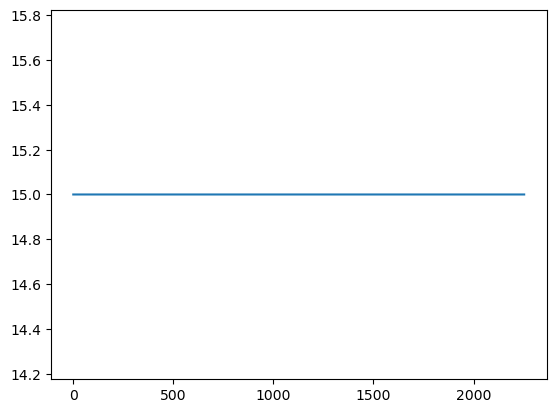

In [103]:
SI = tc.SI(N=tn.N, #number of nodes
           t_simulation=tn.tmax, # maximum time of the simulation (set really
                         # high if sim should end when no infected left)
           infection_rate=0., # infection events per link per unit time
           number_of_initially_infected = 15, # optional, default: 1
           number_of_initially_vaccinated = 0, # optional, default: 0
           save_infection_events = True
           #seed = None, # optional, default: randomly initiated
          )

tc.gillespie_SI(tn, SI)
plt.plot(SI.time, SI.I)
SI.infection_events